In [1]:
import cira

cira.auth.KEY_FILE = ""
assert not cira.auth.check_keys(), "No keys need for this one "

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

In [3]:
SYMBOL = "BTC/USD"
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

ast = cira.Cryptocurrency(SYMBOL)


if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime(2024, 5, 1)
    ast.save_historical_data(SYM_HIST_FILE, start, end)

data = ast.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2021-01-01 06:00:00+00:00,BTC/USD,29255.71,29682.29,28707.56,29676.79,848.874030,29639.0,29316.444625
2021-01-02 06:00:00+00:00,BTC/USD,29678.34,34200.00,29555.99,33769.52,2144.592516,60152.0,31941.412694
2021-01-03 06:00:00+00:00,BTC/USD,33769.52,34812.93,32300.61,32908.02,1838.695433,58725.0,33505.269474
2021-01-04 06:00:00+00:00,BTC/USD,32907.36,33496.03,27900.00,30441.57,2711.189503,69226.0,31267.965121
2021-01-05 06:00:00+00:00,BTC/USD,30461.84,35851.42,29927.55,35063.00,1756.751333,61880.0,33151.367357


<Axes: xlabel='timestamp'>

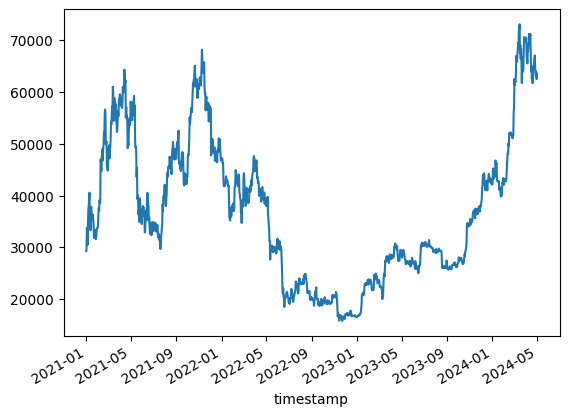

In [4]:
data["open"].plot()

<Axes: xlabel='timestamp'>

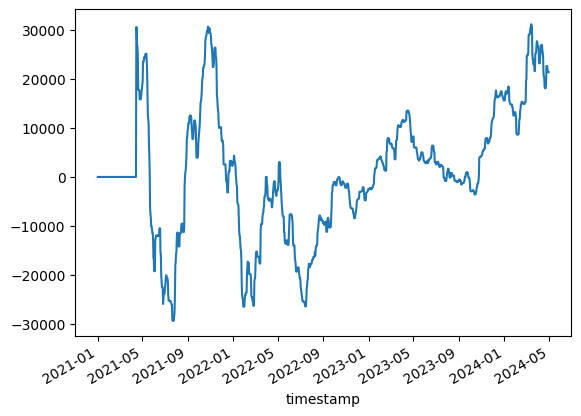

In [5]:
data["diff"] = data["open"].diff(100).rolling(5).median()
data["diff"] = data["diff"].fillna(0)
data["diff"].plot()

In [6]:
classes = {
    "nueatral": 0,
    "light_buy": 1,
    "light_sell": 2,
    "hard_buy": 3,
    "hard_sell":4,
}

In [7]:
LITE = 700
HARD = 1400

data["signal"] = classes["nueatral"]
data.loc[data["diff"] > LITE, "signal"] = classes["light_buy"]
data.loc[data["diff"] < -LITE, "signal"] = classes["light_sell"]
data.loc[data["diff"] > HARD, "signal"] = classes["hard_buy"]
data.loc[data["diff"] < -HARD, "signal"] = classes["hard_sell"]
data["signal"].head(-5)

timestamp
2021-01-01 06:00:00+00:00    0
2021-01-02 06:00:00+00:00    0
2021-01-03 06:00:00+00:00    0
2021-01-04 06:00:00+00:00    0
2021-01-05 06:00:00+00:00    0
                            ..
2024-04-21 05:00:00+00:00    3
2024-04-22 05:00:00+00:00    3
2024-04-23 05:00:00+00:00    3
2024-04-24 05:00:00+00:00    3
2024-04-25 05:00:00+00:00    3
Name: signal, Length: 1211, dtype: int64

In [8]:
data.drop(columns=["symbol"], inplace=True)
data.head()

,open,high,low,close,volume,trade_count,vwap,diff,signal
timestamp,,,,,,,,,
2021-01-01 06:00:00+00:00,29255.71,29682.29,28707.56,29676.79,848.874030,29639.0,29316.444625,0.0,0
2021-01-02 06:00:00+00:00,29678.34,34200.00,29555.99,33769.52,2144.592516,60152.0,31941.412694,0.0,0
2021-01-03 06:00:00+00:00,33769.52,34812.93,32300.61,32908.02,1838.695433,58725.0,33505.269474,0.0,0
2021-01-04 06:00:00+00:00,32907.36,33496.03,27900.00,30441.57,2711.189503,69226.0,31267.965121,0.0,0
2021-01-05 06:00:00+00:00,30461.84,35851.42,29927.55,35063.00,1756.751333,61880.0,33151.367357,0.0,0


In [22]:
split_prc = 0.4
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

1216 486 730


<Axes: xlabel='timestamp'>

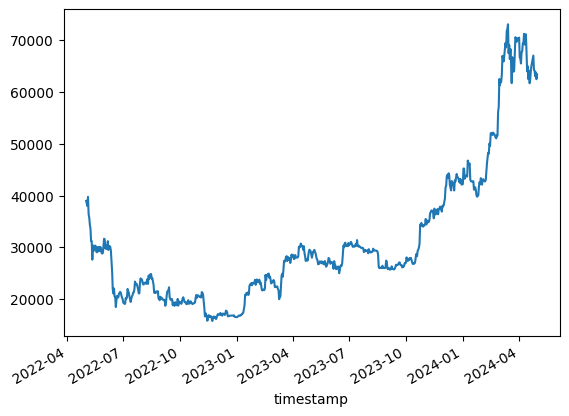

In [23]:
test_data["open"].plot()

In [24]:
X = train_data.drop(columns=["signal", "diff"], inplace=False).values
y = train_data["signal"].values

X.shape, y.shape

((486, 7), (486,))

In [25]:
X_test = test_data.drop(columns=["signal", "diff"], inplace=False).values
y_test = test_data["signal"].values

X_test.shape, y_test.shape

((730, 7), (730,))

<Axes: >

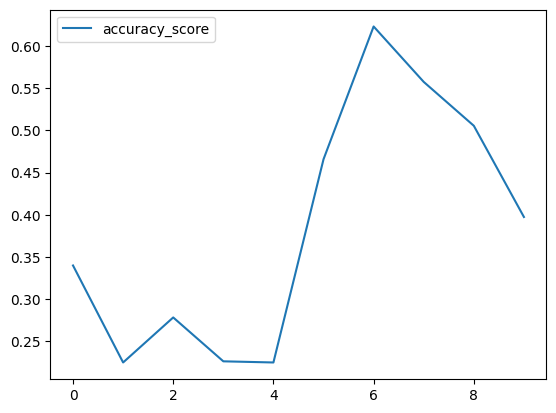

In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

model = MLPClassifier(
            solver="adam",
            hidden_layer_sizes=(100, 50, 25), 
            activation="relu",
            alpha=1e-2, 
            max_iter=400,
            learning_rate_init=0.01,
        )

acc = []
best_model = None
best_acc = 0.0
for i in range(10):
    model = model.fit(X, y)
    y_pred = model.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred, normalize=True))
    if acc[-1] > best_acc:
        best_model = model
model = best_model
pd.DataFrame({"accuracy_score":acc}).plot()

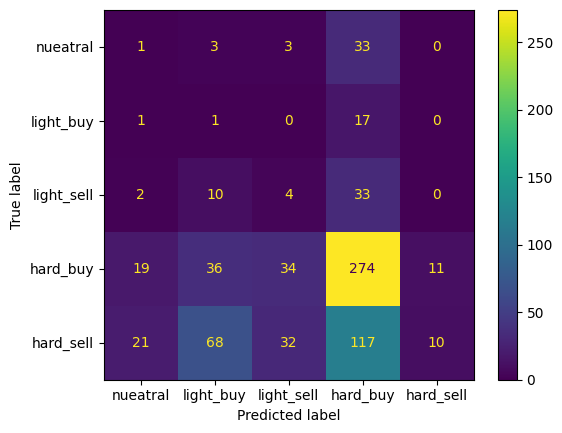

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(classes.keys()))
cmd.plot()


## cira strat

In [38]:

from numpy import ndarray
from pandas import DataFrame


class MLP_Strategy(cira.strategy.Strategy):
    def __init__(self, model:MLPClassifier) -> None:
        super().__init__(name="MLP")
        self.model = model
        self.allocation = list()

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float) -> ndarray:
        pred = model.predict(feature_data.values)[-1]
        actions = {
            classes["nueatral"]: 0,
            classes["light_buy"]: 0.5,
            classes["light_sell"]: -0.5,
            classes["hard_buy"]: 2,
            classes["hard_sell"]: -2,
        }

        while actions[pred] * prices.values[-1] > cash or np.isclose(actions[pred], 0.0):
           actions[pred] -= 0.1

        al = np.array([actions[pred]])
        self.allocation.append(portfolio[-1])
        return al 

Delta: 93704.65$


<Axes: xlabel='timestamp'>

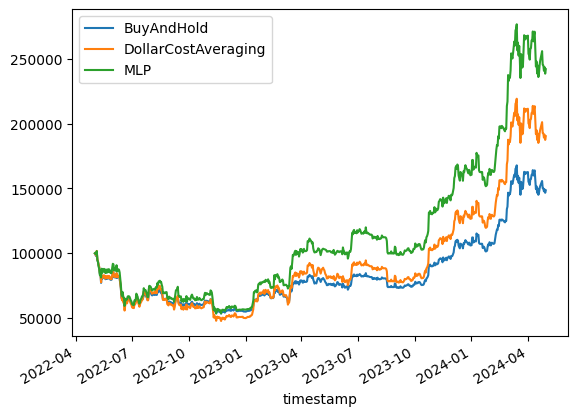

In [46]:
strat = MLP_Strategy(model)
X_backtest = test_data.drop(columns=["signal", "diff"], inplace=False)
bt = cira.strategy.multi_strategy_backtest([cira.strategy.ByAndHold(), cira.strategy.DollarCostAveraging(1), strat], X_backtest, X_backtest["open"].to_frame(), 100_000)
print(f"Delta: {bt[strat.name].values[-1] - bt['BuyAndHold'].values[-1]:.2f}$")
bt.plot()

<Axes: xlabel='timestamp'>

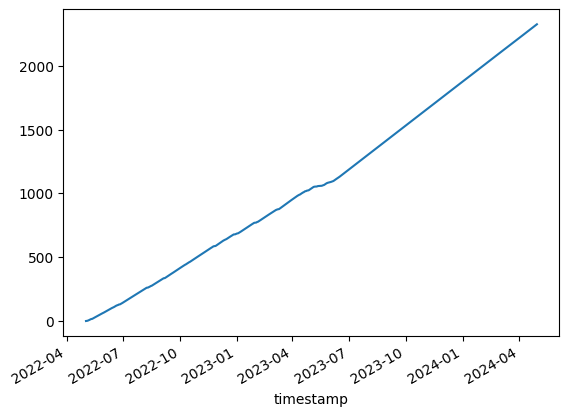

In [47]:
s_all = pd.DataFrame({"allocation":strat.allocation})
s_all.set_index(test_data.index,inplace=True)
s_all["allocation"].cumsum().plot()